In [54]:
import numpy as np
from tools import *
from fitters import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (12,8)})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def test_run(n_series=4, series_rank=3, dim=5, dt=0.1,  e_s=np.array([1.5, 1.0, -0.8]), a_s=None, noise=1e-7, beta=1e-7, window_factor=2.0, method='', iteration=0):

    shape = (n_series, series_rank)
    if a_s is None:
        a_s = np.random.randn(*shape)*0.5

    start_end = (-1, 3)
    time = np.arange(start_end[0], start_end[1]+dt, dt)
    X_series_s, Y_series_s = [], []

    USE_C = False
    for i in range(n_series):
        X_series, Y_series, _, _ = build_exp_series(
            a_s[i], e_s, noise=noise, time=time)
        if len(X_series_s) > 0:
            shift = X_series_s[-1][-1]-X_series[0]
            X_series += shift
            Y_series += shift
        X_series = X_series[1:]
        Y_series = Y_series[1:]
        Xhan = build_hankel(X_series, dim)
        X_series_s.append(X_series)
        Y_series_s.append(Y_series)

    X_series = np.concatenate(X_series_s)
    Y_series = np.concatenate(Y_series_s)

    if method == 'win_noc':
        USE_C = False
        N = len(X_series)
        window = int(dim * window_factor)
        thetas, ws = [], []
        for i in range(window, N, 1):

            sl = slice(i-window, i)
            Xhan = build_hankel(X_series[sl], dim)
            X0w = Xhan[:, :-1]
            Xpw = Xhan[:, 1:]

            Xp1 = Xpw[-1]
            X01 = Xpw
            lam = beta * np.eye(dim)
            a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)

            A = np.eye(dim, k=1)
            A[-1] = a
            w, vl = scipy.linalg.eig(A, left=True, right=False)

            sortorder = np.argsort(np.abs(w))
            w = w[sortorder][::-1]
            theta = vl[:, sortorder][:, -1]
            theta *= np.sign(theta[-1])
            thetas.append(theta)
            ws.append(w)

        ws = np.array(ws)
        thetas = np.array(thetas)
        # window
        Xhan = build_hankel(X_series, dim)
        theta = np.mean(thetas, axis=0)
        P_series = theta.real @ Xhan

    if method == 'win_c':
        USE_C = True
        N = len(X_series)
        window = int(dim * window_factor)
        thetas, ws = [], []
        for i in range(window, N, 1):

            sl = slice(i-window, i)
            Xhan = build_hankel(X_series[sl], dim)
            X0w = Xhan[:, :-1]
            Xpw = Xhan[:, 1:]

            Xp1 = Xpw[-1]
            X01 = np.vstack((X0w, np.ones(X0w.shape[1])))
            reg_dim = dim + 1
            lam = beta * np.eye(reg_dim)

            a = (Xp1 @ X01.T) @ np.linalg.inv((X01 @ X01.T) + lam)
            a, c = a[:-1], a[-1:]
            A = np.eye(dim, k=1)
            A[-1] = a
            w, vl = scipy.linalg.eig(A, left=True, right=False)

            sortorder = np.argsort(np.abs(w))
            w = w[sortorder][::-1]
            theta = vl[:, sortorder][:, -1]
            theta *= np.sign(theta[-1])
            thetas.append(theta)

            ws.append(w)

        ws = np.array(ws)
        thetas = np.array(thetas)
        # window
        Xhan = build_hankel(X_series, dim)
        theta = np.mean(thetas, axis=0)
        P_series = theta.real @ Xhan
        
    if method == 'nowin_c':
        USE_C = True
        P_series, theta, A, c = eig_companion_Cshift(
            X_series, dim, beta=beta)
  
    if method == 'nowin_noc':
        USE_C = False
        P_series, theta, A = eig_companion(X_series, dim, beta=beta)

  
    fit_Y = Y_series[dim:]
    Fit_series = solve_scale_shift(P_series, fit_Y)
    err = mean_square_error(Fit_series, fit_Y)


    result = {
        'MSE': err,
        'theta': theta,
        'C_shift': USE_C,
        'top_e': e_s[np.argmax(np.abs(e_s))]
    }

    return result


In [61]:
dims = [2, 8, 10, 20]
params = {
    # 'dt': [0.05],
    # 'noise': [1e-10,1e-5],
    'e_s': np.array([[1.5, 1.0, -0.8], [-1.5, -1.0, 0.8]]),
    'beta': [1e-8],
    'method': ['win_c', 'win_noc', 'nowin_c', 'nowin_noc'],
    'dim': dims,
    'iteration': np.arange(40),
}
results = param_runner(test_run, params)


[[<matplotlib.axis.XTick at 0x12e47ff70>,

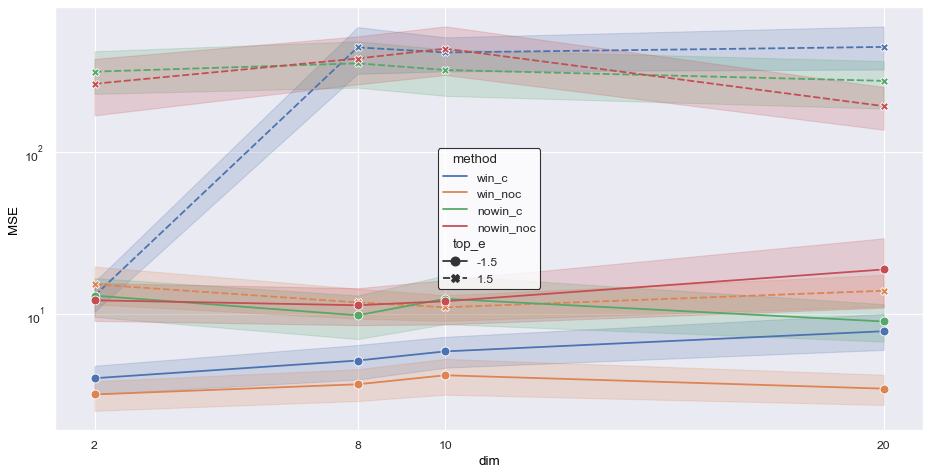

In [62]:
lp = sns.lineplot(x ='dim', y ='MSE', hue='method', style='top_e', markers=True, data=results)
lp.set(yscale='log')
lp.set(xticks=dims)